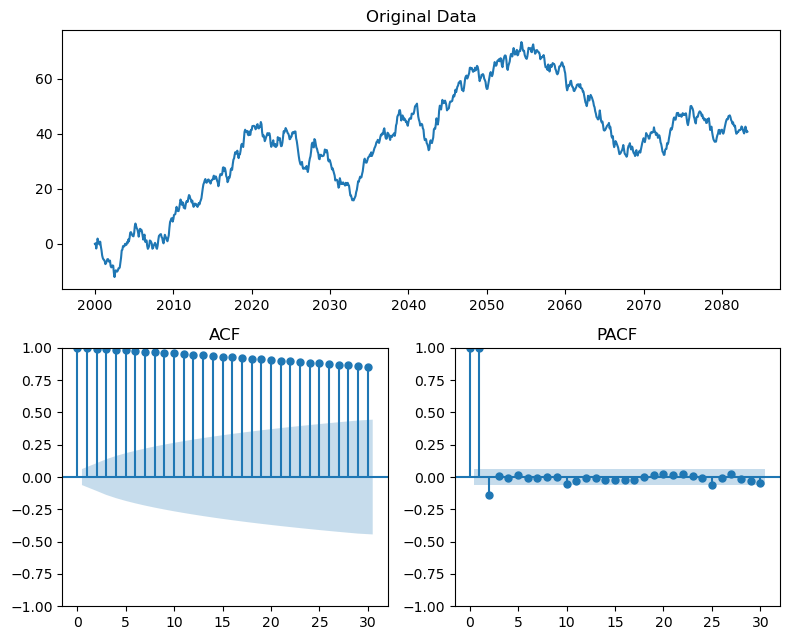

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import numpy as np

# Variable para alternar entre datos artificiales y datos reales
test_with_artificial = True

# Función para generar datos ARIMA artificiales
def artificial_arima(p=np.array([]), d=0, q=np.array([]), f=lambda x: x, n=100, m=0):
    """
    Genera datos artificiales siguiendo un modelo ARIMA.

    Parámetros:
    - p: Coeficientes del modelo AR (AutoRegresivo).
    - d: Número de diferencias (diferenciación).
    - q: Coeficientes del modelo MA (Media Móvil).
    - f: Función de transformación para aplicar a los datos generados.
    - n: Número de puntos a generar.
    - m: Media del ruido blanco agregado.

    Retorna:
    - Serie simulada después de aplicar el modelo ARIMA y la función de transformación.
    """
    a = np.random.normal(0, 1, n)  # Ruido blanco con media 0 y desviación estándar 1
    W = np.zeros(n)  # Serie simulada inicializada con ceros
    for t in range(n):  # Iterar sobre cada punto de tiempo
        if t < len(p) or t < len(q):  # Para evitar índices fuera de rango al inicio
            W[t] = 0  # Los primeros valores se inicializan en 0
        else:
            # Aplicar los coeficientes AR y MA
            W[t] = -W[t-len(p):t] @ p[::-1] + a[t] + a[t-len(q):t] @ q[::-1]

    for d_c in range(d):  # Aplicar diferenciación acumulativa d veces
        W = np.cumsum(W)

    W += m  # Agregar la media
    return f(W)  # Aplicar la transformación

# Generar datos para prueba si se habilita test_with_artificial
if test_with_artificial:
    n = 1000  # Número de puntos simulados
    points = artificial_arima(
        p=np.array([.1]),  # Coeficientes AR
        q=np.array([.5]),  # Coeficientes MA
        d=1,  # Diferenciación
        n=n  # Tamaño de la serie
    )
    # Crear fechas mensuales a partir de enero de 2000
    dates = pd.date_range(start='2000-01-01', periods=n, freq='MS')
    
    # Crear un DataFrame con los puntos simulados y un índice temporal
    time_series_df = pd.DataFrame({'points': points}, index=dates)
else:
    # Cargar datos reales desde un archivo CSV
    time_series_df = pd.read_csv(
        'EUR_USD_monthly.csv',  # Archivo de datos
        parse_dates=[0],  # Parsear la primera columna como fechas
        index_col=0  # Usar la primera columna como índice
    )
    # Convertir los valores a flotantes eliminando comas
    time_series_df['points'] = time_series_df.iloc[:, 0].replace(',', '', regex=True).astype(float)

# Establecer la frecuencia del índice temporal como mensual
time_series_df = time_series_df.asfreq('MS')

# Función para graficar una serie de tiempo, su ACF y PACF
def plot_series(series, series_title, alpha=0.05):
    """
    Grafica una serie de tiempo, su ACF y PACF en un diseño de 2 columnas.

    Parámetros:
    - series: La serie de tiempo a graficar.
    - series_title: Título para la gráfica de la serie de tiempo.
    - alpha: Nivel de significancia para los intervalos de confianza en ACF y PACF.
    """
    # Crear figura con diseño personalizado
    fig = plt.figure(figsize=(8, 6.5))
    gs = fig.add_gridspec(2, 2)  # Crear un diseño de 2 filas y 2 columnas

    # Primera columna: Gráfica de la serie de tiempo
    ax0 = fig.add_subplot(gs[0, :])  # Ocupar toda la primera fila
    ax0.plot(series)  # Graficar la serie
    ax0.set_title(series_title)  # Título de la gráfica

    # Segunda fila, primera columna: Gráfica ACF
    ax1 = fig.add_subplot(gs[1, 0])
    plot_acf(series, ax=ax1, alpha=alpha)  # Graficar la ACF
    ax1.set_title("ACF")  # Título de la ACF

    # Segunda fila, segunda columna: Gráfica PACF
    ax2 = fig.add_subplot(gs[1, 1])
    plot_pacf(series, ax=ax2, alpha=alpha)  # Graficar la PACF
    ax2.set_title("PACF")  # Título de la PACF

    # Ajustar diseño y mostrar gráficas
    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar la serie de tiempo y sus características
plot_series(time_series_df['points'], "Original Data")



Use a full automatic test to which we can compare our results to

In [ ]:
if False:  # Este bloque no se ejecutará porque la condición está configurada como False
    import pmdarima as pm  # Importa la librería pmdarima para modelado automático de ARIMA
    
    # Ajusta automáticamente el mejor modelo ARIMA/SARIMA a los datos de la serie temporal
    model = pm.auto_arima(
        time_series_df,       # Datos de la serie temporal de entrada
        seasonal=False,       # Desactiva el diferenciado estacional
        stepwise=True,        # Activa la búsqueda paso a paso para una selección más rápida del modelo
        trace=True,           # Muestra registros detallados del proceso de ajuste del modelo
        max_p=7,              # Máximo orden de rezago para el componente AR (p)
        max_q=7,              # Máximo orden de rezago para el componente MA (q)
        max_d=1,              # Máximo orden de diferenciación (d) para hacer la serie estacionaria
        max_P=1,              # Máximo orden estacional AR (P) en caso de modelado estacional
        max_Q=1,              # Máximo orden estacional MA (Q) en caso de modelado estacional
        max_D=1,              # Máximo orden de diferenciación estacional (D)
        max_order=10          # Máximo orden combinado de p, q, P y Q para eficiencia
    )
    
    # Muestra un resumen detallado del mejor modelo ARIMA/SARIMA ajustado
    print(model.summary())
    
    # Genera pronósticos para los próximos 12 períodos basados en el modelo ajustado
    forecast = model.predict(n_periods=12)



Test stationarity, Augmented Dickey-Fuller unit root test.

In [ ]:
# Verificar la estacionariedad de la serie temporal
# La hipótesis alternativa de la prueba es que la serie es estacionaria
st.adfuller(time_series_df['points'])  # Realiza la prueba ADF (Augmented Dickey-Fuller) sobre la columna 'points' del DataFrame


(-1.9147257293594082,
 0.3251656879504382,
 3,
 996,
 {'1%': -3.4369325637409154,
  '5%': -2.8644462162311934,
  '10%': -2.568317409920808},
 2787.441519989269)

p value > 0.05 => we can not conclude stationarity

apply box cox transformation, and use scipy to estimate optimal box cox parameter lambda (todo explain what method scipy uses)

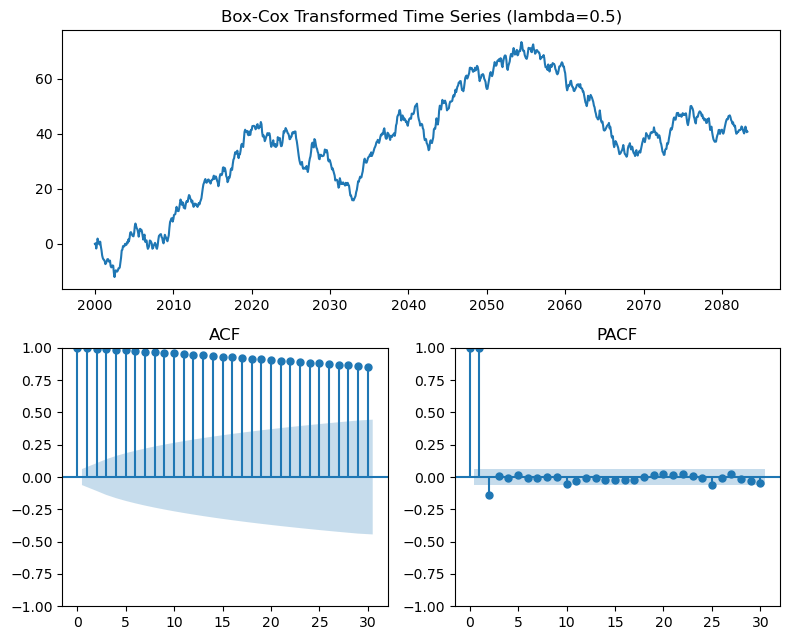

In [ ]:
from scipy import stats  # Importa herramientas estadísticas de la biblioteca SciPy
use_trafo = False  # Define si se debe usar la transformación Box-Cox

if use_trafo:  # Ejecuta la transformación solo si `use_trafo` es True
    # Aplicar la transformación Box-Cox y estimar el valor de lambda
    lmbda = .5  # Valor inicial de lambda; si es None, se estima automáticamente
    if lmbda is None:  # Caso en el que lambda no está definido
        transformed_prices, lmbda = stats.boxcox(time_series_df["points"])  # Aplica Box-Cox y calcula lambda
    else:  # Caso en el que lambda ya está definido
        transformed_prices = stats.boxcox(time_series_df["points"], lmbda=lmbda)  # Aplica Box-Cox con el valor dado de lambda
    
    # Almacena los valores transformados de regreso en el DataFrame
    time_series_df['T_points'] = transformed_prices  # Crea o actualiza la columna con los valores transformados
    print("used lambda: ", lmbda)  # Muestra el valor de lambda utilizado
else:  
    # Si no se aplica transformación, se conserva la serie original
    time_series_df['T_points'] = time_series_df['points']  # Copia los valores originales a la nueva columna

# Graficar la serie transformada o no transformada
plot_series(time_series_df['T_points'], f"Box-Cox Transformed Time Series (lambda={lmbda})")  # Muestra la serie con el título correspondiente



Differentiate and see when stationarity tests become positive

In [ ]:
from scipy import stats  # Importa herramientas estadísticas de la biblioteca SciPy
use_trafo = False  # Define si se debe usar la transformación Box-Cox

if use_trafo:  # Ejecuta la transformación solo si `use_trafo` es True
    # Aplicar la transformación Box-Cox y estimar el valor de lambda
    lmbda = .5  # Valor inicial de lambda; si es None, se estima automáticamente
    if lmbda is None:  # Caso en el que lambda no está definido
        transformed_prices, lmbda = stats.boxcox(time_series_df["points"])  # Aplica Box-Cox y calcula lambda
    else:  # Caso en el que lambda ya está definido
        transformed_prices = stats.boxcox(time_series_df["points"], lmbda=lmbda)  # Aplica Box-Cox con el valor dado de lambda
    
    # Almacena los valores transformados de regreso en el DataFrame
    time_series_df['T_points'] = transformed_prices  # Crea o actualiza la columna con los valores transformados
    print("used lambda: ", lmbda)  # Muestra el valor de lambda utilizado
else:  
    # Si no se aplica transformación, se conserva la serie original
    time_series_df['T_points'] = time_series_df['points']  # Copia los valores originales a la nueva columna

# Graficar la serie transformada o no transformada
plot_series(time_series_df['T_points'], f"Box-Cox Transformed Time Series (lambda={lmbda})")  # Muestra la serie con el título correspondiente






After 1 differencing(s), the ADF p-value is: 1.7167341052607423e-28
Series is stationary after 1 differencings.



Plot the new time series and acf and pcf

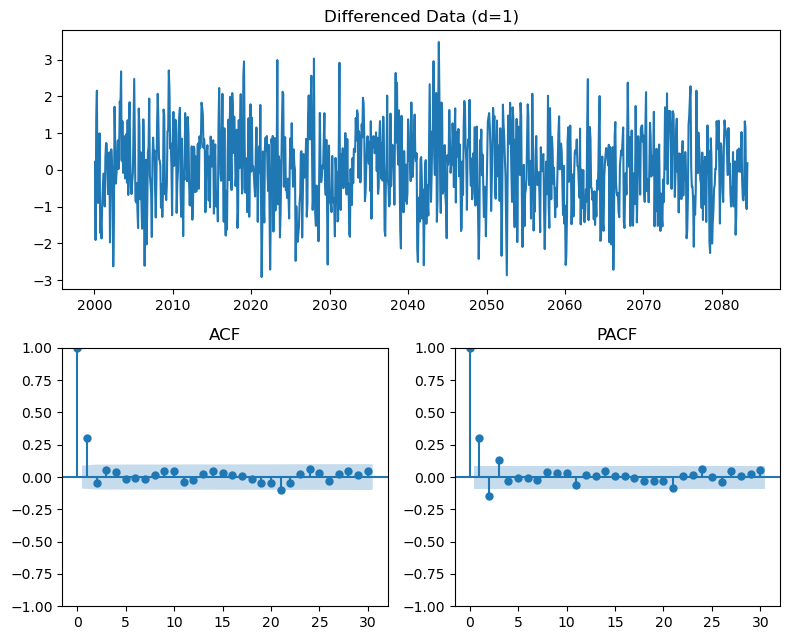

In [ ]:
data = time_series_df['diff_points'].dropna()  # Elimina valores nulos generados por la diferenciación

# Graficar los datos diferenciados con el título correspondiente
plot_series(data, f"Differenced Data (d={differencing_count})", alpha=0.005)  # Muestra la serie diferenciada con el nivel de significancia indicado



Print out all lags that are sginificantly non zero

In [ ]:
data = time_series_df['diff_points'].dropna()  # Elimina los valores nulos generados por la diferenciación

def print_significant_lags(data, alpha=0.005, nlags=40):
    """
    Calcula e imprime los rezagos significativamente diferentes de cero usando ACF y PACF.
    
    Parámetros:
    -----------
    data : array-like
        Los datos de la serie temporal
    alpha : float, por defecto=0.005
        Nivel de significancia para los intervalos de confianza
    nlags : int, por defecto=40
        Número de rezagos a calcular
    
    Retorna:
    --------
    tuple
        - Lista de índices de rezagos significativos
        - Valores de ACF para los rezagos significativos
        - Intervalos de confianza
    """
    # Calcula ACF con intervalos de confianza
    acf_values, acf_confint = st.acf(data, alpha=alpha, fft=True, nlags=nlags, adjusted=True)
    pacf_values, pacf_confint = st.pacf(data, alpha=alpha, nlags=nlags)
    
    # Intervalos de confianza vienen como [inferior, superior] para cada rezago
    # Si 0 no está en [inferior, superior], el rezago es significativo
    acf_significant_lags = []
    acf_significant_values = []
    
    print(f"\nRezagos significativos al nivel de significancia del {alpha*100}%:")
    print("----------------------------------------")
    print("Rezago | Valor ACF | Intervalo de Confianza")
    print("----------------------------------------")
    
    for lag in range(len(acf_values)):
        lower_ci = acf_confint[lag][0]
        upper_ci = acf_confint[lag][1]
        
        # Verifica si 0 está fuera del intervalo de confianza
        if (lower_ci > 0) or (upper_ci < 0):
            acf_significant_lags.append(lag)
            acf_significant_values.append(acf_values[lag])
            print(f"{lag:6d} | {acf_values[lag]:9.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    pacf_significant_lags = []
    pacf_significant_values = []
    
    print(f"\nRezagos significativos al nivel de significancia del {alpha*100}% (PACF):")
    print("----------------------------------------")
    print("Rezago | Valor PACF | Intervalo de Confianza")
    print("----------------------------------------")
    
    for lag in range(len(pacf_values)):
        lower_ci = pacf_confint[lag][0]
        upper_ci = pacf_confint[lag][1]
        
        # Verifica si 0 está fuera del intervalo de confianza
        if (lower_ci > 0) or (upper_ci < 0):
            pacf_significant_lags.append(lag)
            pacf_significant_values.append(pacf_values[lag])
            print(f"{lag:6d} | {pacf_values[lag]:10.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    if not acf_significant_lags and not pacf_significant_lags:
        print("No se encontraron rezagos significativos.")
   
    return (acf_significant_lags, acf_significant_values, acf_confint), (pacf_significant_lags, pacf_significant_values, pacf_confint)

# Llama a la función y almacena los resultados de los rezagos significativos
sig = print_significant_lags(data)



Significant lags at 0.5% significance level:
----------------------------------------
Lag | ACF Value | Confidence Interval
----------------------------------------
  0 |     1.000 | [ 1.000,  1.000]
  1 |     0.303 | [ 0.214,  0.392]
 21 |    -0.099 | [-0.197, -0.000]

Significant lags at 0.5% significance level:
----------------------------------------
Lag | PACF Value | Confidence Interval
----------------------------------------
  0 |      1.000 | [ 1.000,  1.000]
  1 |      0.303 | [ 0.214,  0.392]
  2 |     -0.149 | [-0.238, -0.061]
  3 |      0.130 | [ 0.041,  0.219]


From the significant acf and pacf lags and the acf and pacf graphs we can
propose these models: (TODO adjat models to real life data and add explanations)
ARIMA(5,1,0)
ARIMA(0,1,5)
ARIMA(5,1,5)




## Estimate Parameters


ARIMA(0,1,0):
AIC: 2985.70
BIC: 2990.61

ARIMA(1,1,0):
AIC: 2891.30
BIC: 2901.11

ARIMA(0,1,1):
AIC: 2859.47
BIC: 2869.29

ARIMA(1,1,1):
AIC: 2856.61
BIC: 2871.33

ARIMA(2,1,2):
AIC: 2859.77
BIC: 2884.30


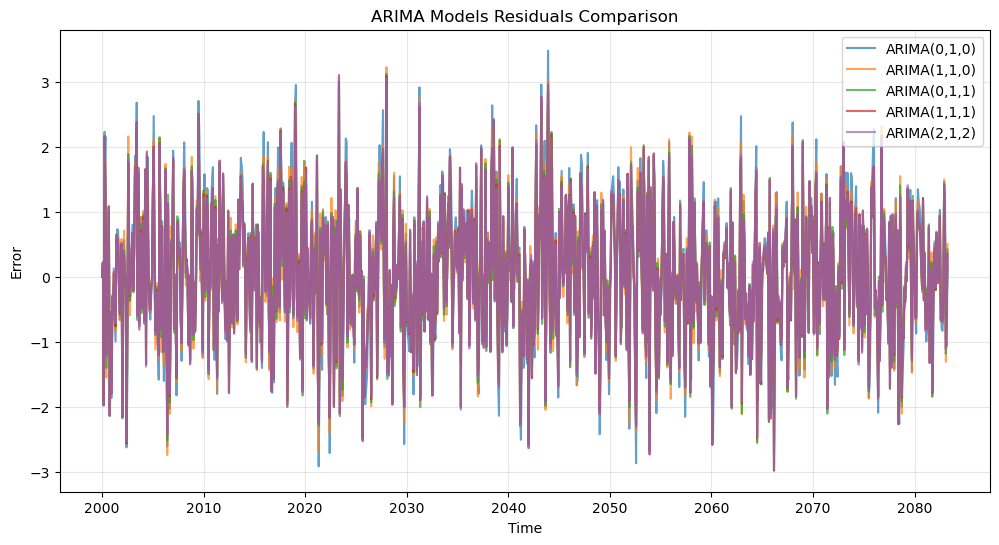

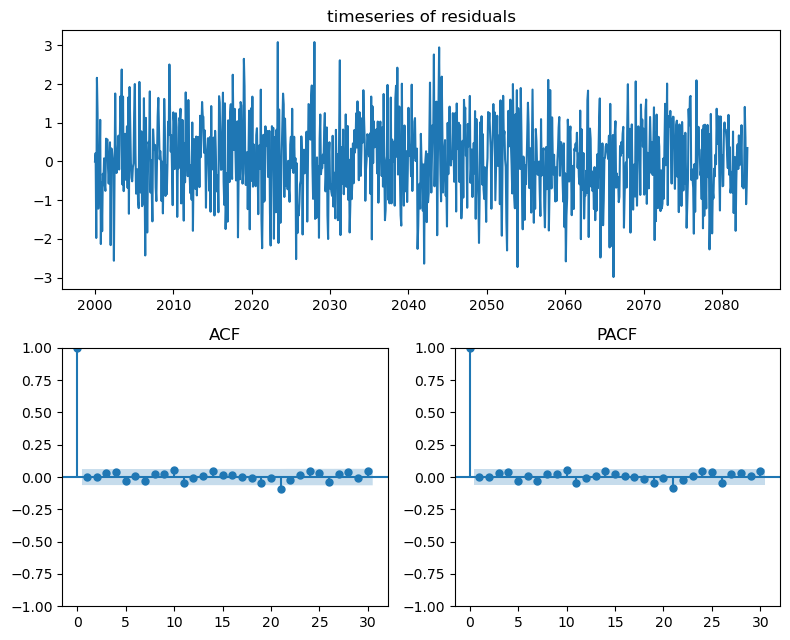

In [ ]:
from statsmodels.tsa.arima.model import ARIMA  # Importa la clase ARIMA para modelado
import numpy as np  # Importa NumPy para manejo de arrays
import pandas as pd  # Importa Pandas para manejo de DataFrames
import matplotlib.pyplot as plt  # Importa Matplotlib para visualización

data = time_series_df['T_points'].dropna()  # Elimina valores nulos de la serie temporal transformada

# Matriz de modelos ARIMA sugeridos (p, d, q)
suggested_models = np.array([
    [0, 1, 0],  # Modelo ARIMA(0,1,0)
    [1, 1, 0],  # Modelo ARIMA(1,1,0)
    [0, 1, 1],  # Modelo ARIMA(0,1,1)
    [1, 1, 1],  # Modelo ARIMA(1,1,1)
    [2, 1, 2]   # Modelo ARIMA(2,1,2)
])

results = []  # Lista para almacenar resultados de cada modelo
error_dfs = []  # Lista para almacenar residuales de cada modelo

# Itera sobre los modelos ARIMA sugeridos
for p, d, q in suggested_models:
    # Ajusta un modelo ARIMA para los parámetros (p, d, q)
    model = ARIMA(data, order=(p, d, q))
    fitted = model.fit()  # Ajusta el modelo
    
    # Guarda los resultados del modelo (AIC, BIC, etc.)
    results.append({
        'order': f"ARIMA({p},{d},{q})",
        'aic': fitted.aic,  # Criterio de Información de Akaike
        'bic': fitted.bic,  # Criterio de Información Bayesiano
        'p': p,
        'd': d,
        'q': q
    })
    
    # Imprime el desempeño del modelo
    print(f"\nARIMA({p},{d},{q}):")
    print(f"AIC: {fitted.aic:.2f}")
    print(f"BIC: {fitted.bic:.2f}")
    
    # Obtiene los residuales del modelo ajustado y los almacena
    residuals = pd.DataFrame(fitted.resid)
    residuals.columns = [f'ARIMA({p},{d},{q})']  # Renombra la columna con el modelo correspondiente
    error_dfs.append(residuals)  # Agrega los residuales a la lista

# Combina todos los residuales en un solo DataFrame
all_errors = pd.concat(error_dfs, axis=1)

# Graficar los residuales de todos los modelos
plt.figure(figsize=(12, 6))
for column in all_errors.columns:
    plt.plot(all_errors.index, all_errors[column], label=column, alpha=0.7)  # Grafica cada modelo
plt.legend()
plt.title('Comparación de Residuales de Modelos ARIMA')  # Título del gráfico
plt.xlabel('Tiempo')  # Etiqueta del eje X
plt.ylabel('Error')  # Etiqueta del eje Y
plt.grid(True, alpha=0.3)  # Activa la cuadrícula con baja opacidad
plt.show()

# Grafica los residuales del modelo ARIMA(1,1,1)
plot_series(all_errors['ARIMA(1,1,1)'], "Serie Temporal de Residuales (ARIMA(1,1,1))")


### Verify 8 supuestos

#### Tests on residuals


In [ ]:

import statsmodels.api as sm  # Importa Statsmodels para análisis estadístico
import matplotlib.pyplot as plt  # Importa Matplotlib para visualización
from scipy.stats import shapiro, jarque_bera  # Importa pruebas de normalidad
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox  # Importa pruebas de homocedasticidad e independencia

# Lista para almacenar los resultados de las pruebas de residuales
residuals_tests = []

data = time_series_df['T_points'].dropna()  # Serie temporal utilizada para ajustar los modelos

# Función para evaluar los residuales de un modelo
def test_residuals(residuals, model_name):
    results = {}
    
    # 1. Verifica si el promedio de los residuales es cercano a 0
    mean_residual = np.mean(residuals)
    results['mean_close_to_0'] = np.isclose(mean_residual, 0, atol=0.01 * np.std(data))  # Dentro de la tolerancia
    print(f"{model_name}: Media de los residuales = {mean_residual:.4f}")
    
    # 2. Verifica varianza constante (Homoscedasticidad) usando la prueba de Breusch-Pagan
    _, pvalue, _, _ = het_breuschpagan(residuals, sm.add_constant(np.arange(len(residuals))))
    results['constant_variance'] = pvalue > 0.05  # Pasa si p-valor > 0.05
    print(f"{model_name}: Homocedasticidad (Breusch-Pagan p-valor) = {pvalue:.4f}")

    # 3. Pruebas de normalidad
    # Prueba Shapiro-Wilk
    _, shapiro_pvalue = shapiro(residuals)
    # Prueba Jarque-Bera
    jb_stat, jb_pvalue = jarque_bera(residuals)
    results['normal_distribution'] = shapiro_pvalue > 0.05 and jb_pvalue > 0.05  # Ambas deben pasar
    print(f"{model_name}: Normalidad (Shapiro-Wilk p-valor) = {shapiro_pvalue:.4f}")
    print(f"{model_name}: Normalidad (Jarque-Bera p-valor) = {jb_pvalue:.4f}")

    # 4. Verifica independencia de los errores usando la prueba Ljung-Box
    # Máximo rezago de 10
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    pvalue_ljungbox = lb_test['lb_pvalue'].values[0]
    results['independent_errors'] = pvalue_ljungbox > 0.05  # Pasa si p-valor > 0.05
    print(f"{model_name}: Independencia (Ljung-Box p-valor) = {pvalue_ljungbox:.4f}")

    # Almacena los resultados en la lista residuals_tests
    residuals_tests.append({'model': model_name, 'results': results})
    
    # (Opcional) Visualización de histogramas y gráficos Q-Q
    if False:  # Cambiar a True para mostrar gráficos
        plt.figure(figsize=(10, 6))
        
        # Histograma de residuales
        plt.subplot(1, 2, 1)
        plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
        plt.title(f'{model_name} Histograma de Residuales')
        plt.axvline(x=0, color='red', linestyle='--', label='Media = 0')
        plt.legend()
        
        # Gráfico Q-Q
        plt.subplot(1, 2, 2)
        sm.qqplot(residuals, line='s')
        plt.title(f'{model_name} Gráfico Q-Q')
        
        plt.tight_layout()
        plt.show()
    
    print("-" * 40)
    
# Itera sobre cada columna de residuales en el DataFrame all_errors
for column in all_errors.columns:
    residuals = all_errors[column].dropna()  # Elimina valores nulos si existen
    test_residuals(residuals, column)  # Evalúa los residuales de cada modelo

# Resumen de los resultados
print("\nResumen de las Pruebas de Residuales:")
for result in residuals_tests:
    model_name = result['model']
    tests = result['results']
    print(f"{model_name}:")
    print(f"  Media cercana a 0: {'Pasa' if tests['mean_close_to_0'] else 'No pasa'}")
    print(f"  Varianza constante: {'Pasa' if tests['constant_variance'] else 'No pasa'}")
    print(f"  Distribución normal: {'Pasa' if tests['normal_distribution'] else 'No pasa'}")
    print(f"  Errores independientes: {'Pasa' if tests['independent_errors'] else 'No pasa'}")
    print("-" * 40)



ARIMA(0,1,0): Mean of residuals = 0.0407
ARIMA(0,1,0): Homoscedasticity (Breusch-Pagan p-value) = 0.0997
ARIMA(0,1,0): Normality (Shapiro-Wilk p-value) = 0.4743
ARIMA(0,1,0): Normality (Jarque-Bera p-value) = 0.2828
ARIMA(0,1,0): Independence (Ljung-Box p-value) = 0.0000
----------------------------------------
ARIMA(1,1,0): Mean of residuals = 0.0284
ARIMA(1,1,0): Homoscedasticity (Breusch-Pagan p-value) = 0.0846
ARIMA(1,1,0): Normality (Shapiro-Wilk p-value) = 0.6653
ARIMA(1,1,0): Normality (Jarque-Bera p-value) = 0.3116
ARIMA(1,1,0): Independence (Ljung-Box p-value) = 0.0000
----------------------------------------
ARIMA(0,1,1): Mean of residuals = 0.0292
ARIMA(0,1,1): Homoscedasticity (Breusch-Pagan p-value) = 0.1142
ARIMA(0,1,1): Normality (Shapiro-Wilk p-value) = 0.7756
ARIMA(0,1,1): Normality (Jarque-Bera p-value) = 0.4208
ARIMA(0,1,1): Independence (Ljung-Box p-value) = 0.1850
----------------------------------------
ARIMA(1,1,1): Mean of residuals = 0.0309
ARIMA(1,1,1): Homosc

## Test 